In [1]:
__author__ = 'Tilii: https://kaggle.com/tilii7' 

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import matplotlib.cm as cm
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    

Simply loading the files without any transformation. If you wish to manipulate the data in any way, it should be done here before doing dimensionality reduction in subsequent steps.

In [2]:
print('\nLoading files ...')
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
X = train.drop(['id', 'target'], axis=1).values
y = train['target'].values.astype(np.int8)
target_names = np.unique(y)
print('\nThere are %d unique target valuess in this dataset:' % (len(target_names)), target_names)


Loading files ...

There are 2 unique target valuess in this dataset: [0 1]


Principal Component Analysis (**[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)**) identifies the combination of  components (directions in the feature space) that account for the most variance in the data.

In [3]:
n_comp = 20
# PCA
print('\nRunning PCA ...')
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X)
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())

print('Individual variance contributions:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])



Running PCA ...
Explained variance: 0.9944
Individual variance contributions:
0.907732701885
0.0254234063215
0.0110337289521
0.0070268753562
0.00628341600314
0.00611974772924
0.00535864726681
0.00453274019813
0.00362930731976
0.00294262288265
0.00239246012144
0.00177464330232
0.00166653490752
0.00151185737228
0.00148285378183
0.00129501399992
0.00120521481347
0.0010727631062
0.00103952906349
0.000841552767779


Better than 90% of the data is explained by a single principal component. Just a shade under 99% of variance is explained by 15 components, which means that this dataset can be safely reduced to ~15 features.

Here we plot our 0/1 samples on the first two principal components.

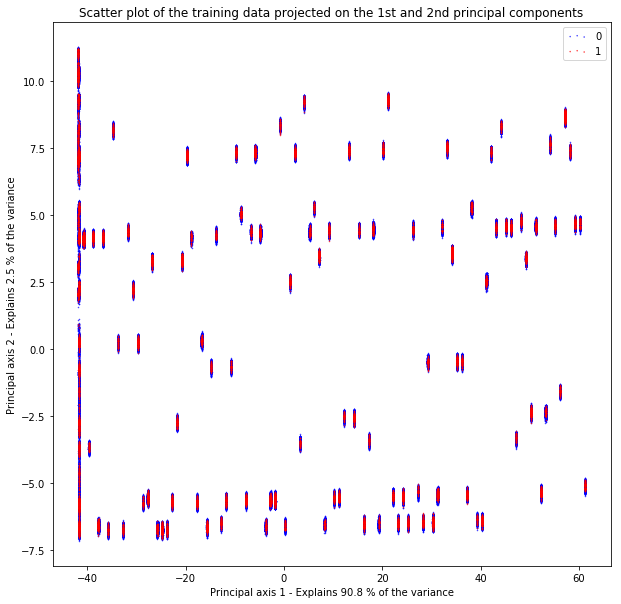

In [4]:
colors = ['blue', 'red']
plt.figure(1, figsize=(10, 10))

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

plt.savefig('pca-porto-01.png', dpi=150)
plt.show()


There is a nice separation between various groups of customers, but not so between 0/1 categories within each group. This is somewhat exaggerated by the fact that "0" points (blue) are plotted first and "1" points (red) are plotted last. There seems to be more red than blue in that image, even though there are >25x "0" points in reality. I'd be grateful if someone knows how to plot this in a way that would not create this misleading impression.

Regardless, 0/1 points are not separated well at all. That means that they will not be easy to classify, which we all know by now.

**[t-SNE](https://lvdmaaten.github.io/tsne/)** could potentially lead to better data separation/visualization, because unlike PCA it preserves the local structure of data points. The problem with sklearn implementation of t-SNE is its lack of memory optimization. I am pretty sure that the t-SNE code at the very bottom will lead to memory errors on most personal computers, but I leave it commented out if anyone wants to try.

Instead, I ran t-SNE using a much faster and more memory-friendly commandline version, which can be found at the link above.

Here is the output of that exercise:

![](https://i.imgur.com/7EqkUWH.png)

Again, we can see clear separation between different groups of customers. Some groups even have a nice "coffee bean" structure where two subgroups can be identified (gender?). Alas, there is no clear separation between 0/1 categories.

In strictly technical terms, we are screwed :D

In [5]:
# tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
# X_tsne = tsne.fit_transform(X) # this will either fail or take a while (most likely overnight)

# plt.figure(2, figsize=(10, 10))

# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], color=color, s=1,
#                 alpha=.8, label=target_name, marker='.')
# plt.legend(loc='best', shadow=False, scatterpoints=3)
# plt.title('Scatter plot of t-SNE embedding')
# plt.xlabel('X')
# plt.ylabel('Y')

# plt.savefig('t-SNE-porto-01.png', dpi=150)
# plt.show()

It was kindly brought up to me that a strange-looking PCA plot above is probably because of categorical variables in this dataset. I leave the original plot up there for posterity.

Let's encode the categorical variables and try again.

In [6]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(X, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

X = train.drop(['id', 'target'], axis=1)
test.drop(['id'], axis=1, inplace=True)
n_train = X.shape[0]
train_test = pd.concat((X, test)).reset_index(drop=True)
col_to_drop = X.columns[X.columns.str.endswith('_cat')]
col_to_dummify = X.columns[X.columns.str.endswith('_cat')].astype(str).tolist()

for col in col_to_dummify:
    dummy = pd.get_dummies(train_test[col].astype('category'))
    columns = dummy.columns.astype(str).tolist()
    columns = [col + '_' + w for w in columns]
    dummy.columns = columns
    train_test = pd.concat((train_test, dummy), axis=1)

train_test.drop(col_to_dummify, axis=1, inplace=True)
train_test_scaled, scaler = scale_data(train_test)
X = np.array(train_test_scaled[:n_train, :])
test = np.array(train_test_scaled[n_train:, :])
print('\n Shape of processed train data:', X.shape)
print(' Shape of processed test data:', test.shape)


 Shape of processed train data: (595212, 227)
 Shape of processed test data: (892816, 227)


Repeating PCA and making another plot of the first two principal components.


Running PCA again ...
Explained variance: 0.6231
Individual variance contributions:
0.074084070101
0.0618868203631
0.0559539511796
0.0427607611418
0.0359086048879
0.0345707250307
0.0314658500583
0.0285582078293
0.0255109028989
0.0252506880295
0.0245827886253
0.0241400322075
0.0238642769192
0.0232114066023
0.021035114187
0.0209135028964
0.020064977449
0.0189478800073
0.0162507118409
0.014169058539


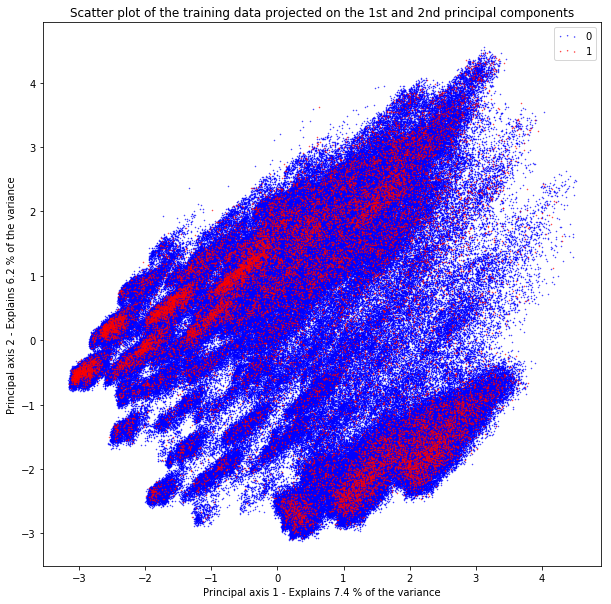

In [7]:
print('\nRunning PCA again ...')
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X)
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())

print('Individual variance contributions:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])

plt.figure(1, figsize=(10, 10))

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

plt.savefig('pca-porto-02.png', dpi=150)
plt.show()

I think that's a better plot visually and there is a good number of well-defined clusters, but still no clear separation between 0/1 points.

We can red-do the t-SNE plot as well using modified dataset. **Don't try this at home** - it takes 24+ hours using a commandline version of bh_tsne.

Anyway, here is the new t-SNE plot:

![](https://i.imgur.com/HYR699D.png)

Again, lots of interesting clusters, but blue and red dots overlap for the most part.

This just happens to be a difficult classification classification problem, so maybe it is not a big surprise that raw data does not contain enough info for t-SNE to distinguish clearly between the classes.

Unfortunately, it is not much better even after training. Below is a t-SNE plot of activations from the last hidden layer (3rd) of a neural network that was trained on this dataset for 80 epochs. If you download the full version (it is roughly 10.5 x 10.5 inches), you may be able to see better that lots of red dots are concetrated in the lower left quadrat (6-9 on a clock dial), and that there are clearly fewer red dots in the upper right quadrant (0-3 on a clock dial). So the network has succeded somewhat in sequestering the red dots, but they still overlap quite a bit with blue ones.

![](https://i.imgur.com/qilITsO.png)

Later I will have more t-SNE plots from neural network activations in [__this kernel__](https://www.kaggle.com/tilii7/keras-averaging-runs-gini-early-stopping).